# Test of the "grand neutrino" collectivisation implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from classy import Class
from time import perf_counter
from copy import deepcopy
from scipy.interpolate import interp1d
def interp_onto(xdata, ydata, xonto):
    interp = interp1d(xdata, ydata)
    return interp(xonto)

In [20]:
# Near degenerate case
masses = [0.0584, 0.0312, 0.03]
#masses = [50, 5, 0.5]
degs   = [1, 1, 1]
Nbins = 5

standard_settings = {
    'H0': 70.0,
    'Omega_cdm': 0.26,
    # etc...
    
    'N_ncdm': len(masses),
    'm_ncdm': ', '.join([str(i) for i in masses]),
    'deg_ncdm': ', '.join([str(i) for i in degs]),

    'Quadrature strategy': '3, 3, 3',
    'Maximum_q': '12, 12, 12',
    'Number of momentum bins': f'{Nbins}, {Nbins}, {Nbins}',
    
#    'output_ncdm_binning': 0,
    'output': 'tCl',
#    'ncdm_fluid_approximation': 0,
}

reference = Class()
reference.set(standard_settings | {'Number of momentum bins': '10000, 10000, 10000', 'Quadrature strategy': '2, 2, 2'})
tic = perf_counter()
reference.compute()
toc = perf_counter()
print(f"Computed reference in {toc - tic:.5} s")

bg_ref = reference.get_background()
a_ref = 1/(1 + bg_ref['z'])

CosmoComputationError: 

Error in Class: perturbations_init(L:1016) :error in perturbations_solve(ppr, pba, pth, ppt, index_md, index_ic, index_k, pppw[thread]);
=>perturbations_solve(L:3335) :error in generic_evolver(perturbations_derivs, interval_limit[index_interval], interval_limit[index_interval+1], ppw->pv->y, ppw->pv->used_in_sources, ppw->pv->pt_size, &ppaw, ppr->tol_perturbations_integration, ppr->smallest_allowed_variation, perturbations_timescale, ppr->perturbations_integration_stepsize, ppt->tau_sampling, tau_actual_size, perturbations_sources, perhaps_print_variables, ppt->error_message);
=>evolver_ndf15(L:187) :error in initialize_jacobian(&jac,neq,error_message);
=>initialize_jacobian(L:1574) :could not allocate jac->Ci with size -8

In [3]:
separate = Class()
separate.set(standard_settings)
tic = perf_counter()
separate.compute()
toc = perf_counter()
print(f"Computed {len(masses)} separate species in {toc - tic:.5} s")

collective = Class()
collective.set(standard_settings | {'collective_ncdm': 1})
tic = perf_counter()
collective.compute()
toc = perf_counter()
print(f"Computed {len(masses)} collective species in {toc - tic:.5} s")

Computed 3 separate species in 0.068621 s
Computed 3 collective species in 0.04097 s


Pretty OK speed-up, about factor 2 in background.

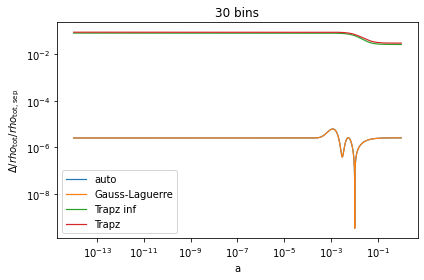

In [18]:
def get_density_error(Nbins, strategy=1):
    collective = Class()
    collective.set(standard_settings | {'collective_ncdm': 1, 'Number of momentum bins': f'{Nbins}, {Nbins}, {Nbins}', 'Quadrature strategy': f'{strategy}, {strategy}, {strategy}'})
    collective.compute()
    bg_col = collective.get_background()
    a_col = 1/(1 + bg_col['z'])
    rho_tot_ref = interp_onto(a_ref, np.sum(np.vstack([bg_ref[f'(.)rho_ncdm[{idx}]'] for idx in range(len(masses))]), axis=0), a_col)
    error = (bg_col['(.)rho_ncdm[0]'] - rho_tot_ref)/rho_tot_ref
    return a_col, error

bins = 10

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_title(f'{Nbins} bins')
ax.set(xlabel='a', ylabel=r'$\Delta /rho_\mathrm{tot}/rho_\mathrm{tot,sep}$', xscale='log', yscale='log')

a_auto, error_auto = get_density_error(bins, strategy=0)
ax.plot(a_auto, np.abs(error_auto), '-', lw=1.2, label='auto')

a_lag, error_lag = get_density_error(bins, strategy=1)
ax.plot(a_lag, np.abs(error_lag), '-', lw=1.2, label='Gauss-Laguerre')

a_trapz_inf, error_trapz_inf = get_density_error(bins, strategy=2)
ax.plot(a_trapz_inf, np.abs(error_trapz_inf), '-', lw=1.2, label='Trapz inf')

a_trapz, error_trapz = get_density_error(bins, strategy=3)
ax.plot(a_trapz, np.abs(error_trapz), '-', lw=1.2, label='Trapz')

ax.legend(loc='lower left')
fig.tight_layout()
fig.savefig('density_error.pdf')

In [7]:
def get_ini_rho_error(Nbins, strategy=1, auto_tol=None):
    collective = Class()
    if strategy == 0:
        # +10 bins is approximately required to reduce tol_ncdm_bg by 1 order of mag
        if auto_tol is None:
            collective.set(standard_settings | {'collective_ncdm': 1, 'output_ncdm_binning': 1, 'Quadrature strategy': f'{strategy}, {strategy}, {strategy}'})
        elif auto_tol == 'bin':
            auto_tol = 1e-5*0.1*(Nbins/10)
            collective.set(standard_settings | {'collective_ncdm': 1, 'output_ncdm_binning': 1, 'Quadrature strategy': f'{strategy}, {strategy}, {strategy}', 'tol_ncdm_bg': auto_tol})
        else:
            collective.set(standard_settings | {'collective_ncdm': 1, 'output_ncdm_binning': 1, 'Quadrature strategy': f'{strategy}, {strategy}, {strategy}', 'tol_ncdm_bg': auto_tol})
    else:
        collective.set(standard_settings | {'collective_ncdm': 1, 'Number of momentum bins': f'{Nbins}, {Nbins}, {Nbins}', 'Quadrature strategy': f'{strategy}, {strategy}, {strategy}'})
        bins = Nbins
    collective.compute()

    bg_col = collective.get_background()
    if strategy == 0:
        # Get amount of bins
        max_bin_idx = np.argmax([bg_col[f'q_ncdm[0][{idx}]'][0] for idx in range(1000) if f'q_ncdm[0][{idx}]' in bg_col])
        print(f"Automatic quadrature has {max_bin_idx} bins at a tol_ncdm_bg={auto_tol}.")
        bins = max_bin_idx
    a_col = 1/(1 + bg_col['z'])
    rho_tot_ref = interp_onto(a_ref, np.sum(np.vstack([bg_ref[f'(.)rho_ncdm[{idx}]'] for idx in range(len(masses))]), axis=0), a_col)

    error = (bg_col['(.)rho_ncdm[0]'] - rho_tot_ref)/rho_tot_ref
    return bins, error[0]

In [8]:
binlist = [5, 10, 50, 90, 250, 500, 1000]
laguerre_cut = 110

results = {}
strategies = ['auto', 'auto_tol', 'laguerre', 'trapz_inf', 'trapz']
auto_tol = 1e-2
for kw in strategies:
    results[kw] = {
        'bins': [],
        'error': []
    }

auto_bins, auto_error = get_ini_rho_error(bin, strategy=0)
results['auto']['bins'].append(auto_bins)
results['auto']['error'].append(auto_error)

auto_tol_bins, auto_tol_error = get_ini_rho_error(bin, strategy=0, auto_tol=1e-2)
results['auto_tol']['bins'].append(auto_tol_bins)
results['auto_tol']['error'].append(auto_tol_error)

for bin in binlist:
    if bin < laguerre_cut:
        laguerre_bins, laguerre_error = get_ini_rho_error(bin, strategy=1)
        results['laguerre']['bins'].append(laguerre_bins)
        results['laguerre']['error'].append(laguerre_error)

    trapz_inf_bins, trapz_inf_error = get_ini_rho_error(bin, strategy=2)
    results['trapz_inf']['bins'].append(trapz_inf_bins)
    results['trapz_inf']['error'].append(trapz_inf_error)

    trapz_bins, trapz_error = get_ini_rho_error(bin, strategy=3)
    results['trapz']['bins'].append(trapz_bins)
    results['trapz']['error'].append(trapz_error)

Automatic quadrature has 9 bins at a tol_ncdm_bg=None.
Automatic quadrature has 5 bins at a tol_ncdm_bg=0.01.


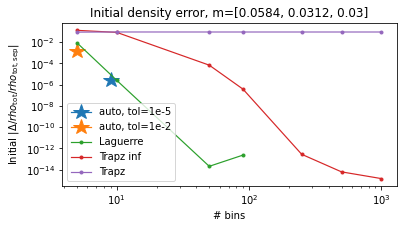

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.set_title(f'Initial density error, m={masses}')
ax.set(xlabel='# bins', ylabel=r'Initial $|\Delta /rho_\mathrm{tot}/rho_\mathrm{tot,sep}|$', xscale='log', yscale='log')

ax.plot(results['auto']['bins'], np.abs(results['auto']['error']), '*-', lw=1.2, ms=16, label='auto, tol=1e-5')
ax.plot(results['auto_tol']['bins'], np.abs(results['auto_tol']['error']), '*-', ms=16, lw=1.2, label='auto, tol=1e-2')
ax.plot(results['laguerre']['bins'], np.abs(results['laguerre']['error']), '.-', lw=1.2, label='Laguerre')
ax.plot(results['trapz_inf']['bins'], np.abs(results['trapz_inf']['error']), '.-', lw=1.2, label='Trapz inf')
ax.plot(results['trapz']['bins'], np.abs(results['trapz']['error']), '.-', lw=1.2, label='Trapz')

ax.legend()
fig.savefig('precision.pdf')

In [14]:
def get_binning(bins, strategy=3, auto_tol=None):
    lag_cut = 90
    collective = Class()
    if strategy == 0:
        # +10 bins is approximately required to reduce tol_ncdm_bg by 1 order of mag
        if auto_tol == 'bin':
            auto_tol = 1e-5*0.1*(bins/10)
            collective.set(standard_settings | {'collective_ncdm': 1, 'output_ncdm_binning': 1, 'Quadrature strategy': f'{strategy}, {strategy}, {strategy}', 'tol_ncdm_bg': auto_tol})
        elif auto_tol is None:
            new_settings = deepcopy(standard_settings) | {'collective_ncdm': 1, 'output_ncdm_binning': 1, 'Quadrature strategy': f'{strategy}, {strategy}, {strategy}'}
            del new_settings['Number of momentum bins']
            del new_settings['Maximum_q']
            collective.set(new_settings)
        else:
            collective.set(standard_settings | {'collective_ncdm': 1, 'output_ncdm_binning': 1, 'Quadrature strategy': f'{strategy}, {strategy}, {strategy}', 'tol_ncdm_bg': auto_tol})
    else:
        if strategy == 1:
            if bins > lag_cut:
                bins = lag_cut
        qmax = 1e+2
        collective.set(standard_settings | {'collective_ncdm': 1, 'output_ncdm_binning': 1, 'Number of momentum bins': f'{bins}, {bins}, {bins}', 'Quadrature strategy': f'{strategy}, {strategy}, {strategy}', 'Maximum_q': f'{qmax}, {qmax}, {qmax}'})
    collective.compute()
    bg = collective.get_background()
    print(bg.keys())
    if strategy == 0:
        # Get amount of bins
        max_bin_idx = np.argmax([bg[f'q_ncdm[0][{idx}]'][0] for idx in range(1000) if f'q_ncdm[0][{idx}]' in bg])
        print(f"Automatic quadrature has {max_bin_idx} bins at target {bins} bins.")
        qlist = [bg[f'q_ncdm[0][{idx}]'][0] for idx in range(max_bin_idx)]
        wlist = [bg[f'w_ncdm[0][{idx}]'][0] for idx in range(max_bin_idx)]
        return np.array(qlist), np.array(wlist), max_bin_idx
    else:
        qlist = [bg[f'q_ncdm[0][{idx}]'][0] for idx in range(bins)]
        wlist = [bg[f'w_ncdm[0][{idx}]'][0] for idx in range(bins)]
        return np.array(qlist), np.array(wlist)
    

dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_ncdm[0]', '(.)p_ncdm[0]', 'q_ncdm[0][0]', 'w_ncdm[0][0]', 'q_ncdm[0][1]', 'w_ncdm[0][1]', 'q_ncdm[0][2]', 'w_ncdm[0][2]', 'q_ncdm[0][3]', 'w_ncdm[0][3]', 'q_ncdm[0][4]', 'w_ncdm[0][4]', 'q_ncdm[0][5]', 'w_ncdm[0][5]', 'q_ncdm[0][6]', 'w_ncdm[0][6]', 'q_ncdm[0][7]', 'w_ncdm[0][7]', 'q_ncdm[0][8]', 'w_ncdm[0][8]', 'q_ncdm[0][9]', 'w_ncdm[0][9]', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])
Automatic quadrature has 9 bins at target 253 bins.
dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_ncdm[0]', '(.)p_ncdm[0]', 'q_ncdm[0][0]', 'w_ncdm[0][0]', 'q_ncdm[0][1]', 'w_ncdm[0][1]', 'q_ncdm[0][2]', 'w_ncdm[0][2]', 

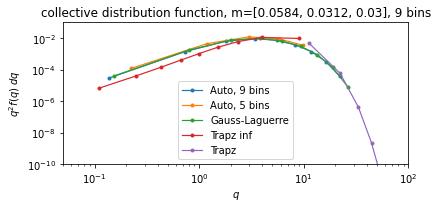

In [17]:
bins = 253

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

ax.set(xlabel=r'$q$', ylabel=r'$q^2 f(q) \ dq$', xscale='linear', yscale='linear')

q_auto, w_auto, auto_bins = get_binning(bins, strategy=0)
ax.plot(q_auto, q_auto**2*w_auto, '.-', lw=1.2, label=f'Auto, {auto_bins} bins')

bins = auto_bins
ax.set_title(f'collective distribution function, m={masses}, {bins} bins')

q_auto_tol, w_auto_tol, auto_bins_tol = get_binning(bins, strategy=0, auto_tol=1e-2)
ax.plot(q_auto_tol, q_auto_tol**2*w_auto_tol, '.-', lw=1.2, ms=6, label=f'Auto, {auto_bins_tol} bins')

q_lag, w_lag = get_binning(bins, strategy=1)
ax.plot(q_lag, q_lag**2*w_lag, '.-', lw=1.2, label='Gauss-Laguerre')

q_trapz_inf, w_trapz_inf = get_binning(bins, strategy=2)
ax.plot(q_trapz_inf, q_trapz_inf**2*w_trapz_inf, '.-', lw=1.2, label='Trapz inf')

q_trapz, w_trapz = get_binning(bins, strategy=3)
ax.plot(q_trapz, q_trapz**2*w_trapz, '.-', lw=1.2, label='Trapz')

#ax.set(xlim=[0.05, 5000], xscale='log')
#ax.set(ylim=[4e-9, 1e-2], yscale='log')

#ax.set(xlim=[0.05, 1e+6], xscale='log')
#ax.set(ylim=[1e-12, 1e-2], yscale='log')

ax.set(xlim=[0.05, 1e+2], xscale='log')
ax.set(ylim=[1e-10, 1e-1], yscale='log')

ax.legend()
fig.tight_layout()
fig.savefig('binning.pdf')

# Perturbations

Massive speed-up in perturbations! About a factor 4 when including perturbations!

In [31]:
def get_delta_nu(bins, k_output_value=0.2, strategy=1):
    collective = Class()
    extra_settings = {
        'collective_ncdm': 1, 
        'Number of momentum bins': f'{bins}, {bins}, {bins}', 
        'Quadrature strategy': f'{strategy}, {strategy}, {strategy}',
        'output': 'tCl, mPk',
        'k_output_values': k_output_value
    }
    collective.set(standard_settings | extra_settings)
    collective.compute()
    pt = collective.get_perturbations()['scalar'][0]
    return pt['tau [Mpc]'], pt['delta_ncdm[0]']

klist = np.logspace(-3, 1, 10)
delta_nu_list = []
tau_list = []
for k in klist:
    tau, delta_nu = get_delta_nu(10, k_output_value=k)
    delta_nu_list.append(delta_nu)
    tau_list.append(tau)

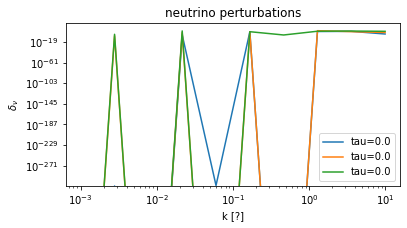

In [32]:
tau_indices = [0, 250, -1]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.set_title(f'neutrino perturbations')
ax.set(xlabel='k [?]', ylabel=r'$\delta_\nu$', xscale='log', yscale='log')
for tau_idx in tau_indices:
    delta_nu_k = [delta_nu_list[k_idx][tau_idx] for k_idx in range(len(klist))]
    ax.plot(klist, np.abs(delta_nu_k), label=f'tau={tau_list[0][tau_idx]}')
ax.legend()
